In [2]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='AppleGothic') #맥

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# product data
product36 = pd.read_csv('product36.csv')

In [4]:
# 상품 이름을 보고 카테고리 분류
def name_categorize_category(row):
    if any(keyword in row['hits_product_v2ProductName'] for keyword in ['Toddler','Youth','Women','Men','Bib', 'Dress Socks','Vintage Henley','Tee', 'Sweatshirt', 'Jacket', 'Cap', 'Zip', 'Sleeve' , 'Hoodie', 'Hat', 'Onesie', 'Vest', 'Baby', 'Shirt']):
        return 'Apparel'
    elif any(keyword in row['hits_product_v2ProductName'] for keyword in ['Set of 3 Nested Travel Cases','Foldaway Shopper','Chevron Shopper','Collapsible Duffel','Backpack','Electronics Accessory Pouch','Bag', 'Rucksack', 'Softsided Travel Pouch Set', 'Backpack', 'Tote']):
        return 'Bags' 
    elif any(keyword in row['hits_product_v2ProductName'] for keyword in ['Nest® Learning Thermostat 3rd Gen-USA','PowerKit','Headset','Google Device Holder Sticky Pad','Charger','Grip Kit Cable Organizer','Device Stand','Micro Charger','Phone Holder','Compact Selfie Stick','Waze Mobile Phone Vent Mount','Speaker', 'Compact Charger','Bluetooth', 'Flashlight', 'Earbuds', 'Power Bank']):
        return 'Electronics' 
    elif any(keyword in row['hits_product_v2ProductName'] for keyword in ['Android 24 oz Contigo Addison','Koozie Can Kooler','Bottle', 'Mug', 'Tumbler', 'Cups']):
        return 'Drinkware'
    elif any(keyword in row['hits_product_v2ProductName'] for keyword in ['Set of 3 Packing Cubes','Google Badge Pull','Screen Cleaning Cloth','Notebook', 'Journal', 'Pen', 'Mouse Pad', 'Badge Holder', 'Galaxy Screen Cleaning Cloth']):
        return 'Office' 
    elif any(keyword in row['hits_product_v2ProductName'] for keyword in ['Gift Card']):
        return 'Gift Card' 
    elif any(keyword in row['hits_product_v2ProductName'] for keyword in ['Android Cool Gear Lunch To Go','Google 7-inch Dog Flying Disc','Pop-a-Point Crayon','Yoga Block','Android Lunch Kit','9 Decal Set','Beach Mat','Yoga Mat','Pet Feeding Mat','Luggage Tag','Dog Frisbee','Waze Mood Window Decal','Kick Ball','Seat Pack Organizer','Pet Bowl','Sanitizer','Windup Android','Umbrella','Sticker', 'Dog Toy', 'Doodle Decal', 'Custom Decals', '7" Dog Frisbee', 'Lip Balm', 'Suitcase Organizer Cubes', 'Sunglasses']):
        return 'Accessories' 
    else:
        return row['name_category']

product36['name_category'] = product36.apply(name_categorize_category, axis=1)

In [5]:
product36

,fullVisitorId,visitId,visitNumber,hits_hitNumber,hits_eCommerceAction_action_type,hits_product_v2ProductName,hits_product_v2ProductCategory,hits_product_productPrice,hits_product_productQuantity,hits_product_productRevenue,hits_product_productRefundAmount,hits_product_productListPosition,hits_product_productCouponCode,hits_product_productListName,hits_product_isClick,name_category,labels
0,6204463650092781278,1498226377,7,49,3,Google Tote Bag,${escCatTitle},9.99,1.0,NaN,NaN,0,NaN,(not set),NaN,Bags,0.0
1,4792870216119315911,1492530532,2,16,3,Foam Can and Bottle Cooler,Home/Accessories/Housewares/,1.99,10.0,NaN,NaN,0,NaN,(not set),NaN,Drinkware,0.0
2,2346359290191771618,1493828053,10,81,6,Google Tote Bag,Bags,9.99,1.0,10.08,NaN,0,NaN,(not set),NaN,Bags,0.0
3,9067391538272092242,1479219404,2,133,6,Google Men's Quilted Insulated Vest Black,Apparel,59.99,1.0,60.49,NaN,0,NaN,(not set),NaN,Apparel,0.0
4,8519577869545508855,1490150072,1,17,3,Google Wool Heather Cap Heather/Navy,${escCatTitle},24.99,1.0,NaN,NaN,0,NaN,(not set),NaN,Apparel,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78942,817007348095653854,1474913645,2,105,6,YouTube Men's Short Sleeve Hero Tee(3),(not set),15.19,2.0,30.94,NaN,0,NaN,(not set),NaN,Apparel,0.0
78943,2130970500799303391,1482300504,2,18,3,Google Women's Fleece Hoodie,Home/Apparel/Women's/Women's-Outerwear/,44.79,1.0,NaN,NaN,0,NaN,(not set),NaN,Apparel,0.0
78944,5615659499306558316,1471965186,5,42,3,YouTube Men's Short Sleeve Hero Tee(3),Home/Shop by Brand/YouTube/,18.99,2.0,NaN,NaN,0,NaN,(not set),NaN,Apparel,0.0
78945,747690048733385763,1472823219,2,24,3,Google Men's Vintage Badge Tee(4),Home/Apparel/Men's/Men's-T-Shirts/,16.99,1.0,NaN,NaN,0,NaN,(not set),NaN,Apparel,0.0


In [22]:
product36['name_category'].unique()

array(['Bags', 'Drinkware', 'Apparel', 'Office', 'Electronics',
       'Accessories', 'Gift Card'], dtype=object)

In [6]:
product36['hits_product_productQuantity'].describe()

count    74149.000000
mean         7.214622
std         29.226810
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1000.000000
Name: hits_product_productQuantity, dtype: float64

In [7]:
clustering = pd.read_csv('clustering.csv')
clustering

,fullVisitorId,labels
0,213131142648941,0
1,435324061339869,0
2,562678147042735,0
3,585708896049892,0
4,852801263780322,0
...,...,...
9416,9991633376050115277,0
9417,9994767073213036303,0
9418,9997409246962677759,0
9419,9998597322098588317,0


In [8]:
product36.groupby('labels')['hits_product_productQuantity'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0.0,71213.0,5.930673,21.381270,1.0,1.0,1.0,3.0,1000.0
1.0,591.0,83.932318,176.656361,1.0,6.0,19.0,53.0,1000.0
2.0,261.0,30.030651,80.343440,1.0,1.0,2.0,13.0,500.0
3.0,2084.0,26.475048,54.500039,1.0,3.0,10.0,25.0,1000.0


In [9]:
product36.groupby('labels')['fullVisitorId'].nunique()

labels
0.0    9392
1.0       1
2.0       2
3.0      26
Name: fullVisitorId, dtype: int64

군집0: 평균 구매수량 5.9, 평균 제품 가격 18.4, 최대 구매수량 1000.0
군집1: 평균 구매수량 83.9, 평균 제품 가격 33.6, 최대 구매수량 1000.0
군집2: 평균 구매수량 30.0, 평균 제품 가격 16.3, 최대 구매수량 500.0
군집3: 평균 구매수량 26.5, 평균 제품 가격 16.6, 최대 구매수량 1000.0


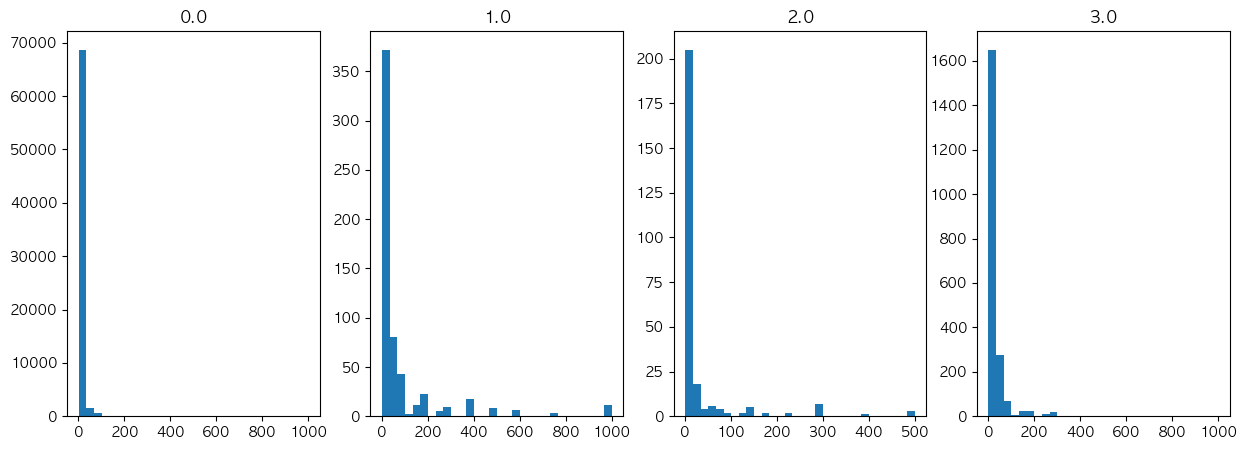

In [10]:
# 군집에 따른 구매 수량 분포 확인
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (name, group) in enumerate(product36.groupby('labels')):
    mean_num = round(group['hits_product_productQuantity'].mean(), 1)
    mean_price = round(group['hits_product_productPrice'].mean(), 1)
    max_num = group['hits_product_productQuantity'].max()
    print(f'군집{int(name)}: 평균 구매수량 {mean_num}, 평균 제품 가격 {mean_price}, 최대 구매수량 {max_num}')
    axs[i].hist(group['hits_product_productQuantity'], bins=30)
    axs[i].set_title(f"{name}")

1000번 구매 총 구매 고객 3 명, 값 평균 1.7 달러, 매출 평균 1743.6 달러
[1. 0. 3.]


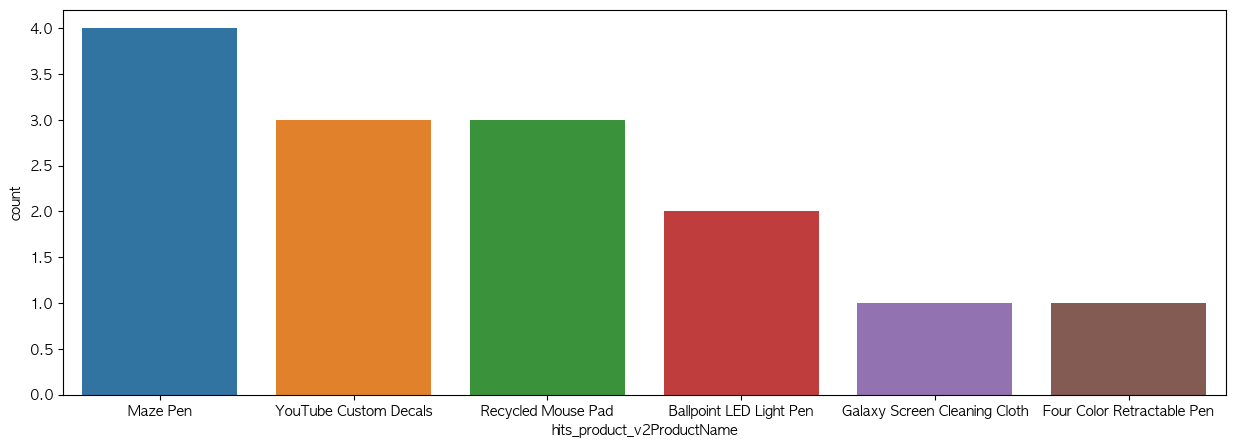

In [11]:
thousands = product36[product36['hits_product_productQuantity'] == 1000.0]
id_num = thousands['fullVisitorId'].nunique()
labels = thousands['fullVisitorId'].unique()
labels = thousands[thousands['fullVisitorId'].isin(labels)]['labels'].unique()
thousands['revenue'] = thousands['hits_product_productPrice'] * thousands['hits_product_productQuantity']
price_mean = round(thousands['hits_product_productPrice'].mean(), 1)
revenue_mean = round(thousands['revenue'].mean(), 1)

plt.figure(figsize=(15, 5))
sns.countplot(x = 'hits_product_v2ProductName',
              data = thousands,
              order = thousands['hits_product_v2ProductName'].value_counts().index)    

print(f'1000번 구매 총 구매 고객 {id_num} 명, 값 평균 {price_mean} 달러, 매출 평균 {revenue_mean} 달러')
print(f'{labels}')

In [12]:
# 1번 과 2번, 3번의 지역, 회사명 파악 + 시간대

In [16]:
zero = product36[product36['labels'] == 0]
zero = zero[zero['hits_eCommerceAction_action_type'] == 6]
zero['hits_product_productQuantity'].mean()

5.471083969465649

In [ ]:
# 0번 고객은 